# Analysis of ChIP-seq simulation

In [1]:

%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [2]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [3]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

,Modification,Model,k,theta,prc_rate,f,s
0,H3K27ac,/home/jetbrains/data/2023_chips/models/H3K27ac...,9.956003,28.346699,1.0,0.017982,0.546500
1,H3K27me3,/home/jetbrains/data/2023_chips/models/H3K27me...,7.220823,33.285236,1.0,0.027236,0.350808
2,H3K36me3,/home/jetbrains/data/2023_chips/models/H3K36me...,10.078997,28.173210,1.0,0.040442,0.704835
3,H3K4me1,/home/jetbrains/data/2023_chips/models/H3K4me1...,6.960485,33.901993,1.0,0.025245,0.781072
4,H3K4me3,/home/jetbrains/data/2023_chips/models/H3K4me3...,5.570499,37.896400,1.0,0.006748,0.748189


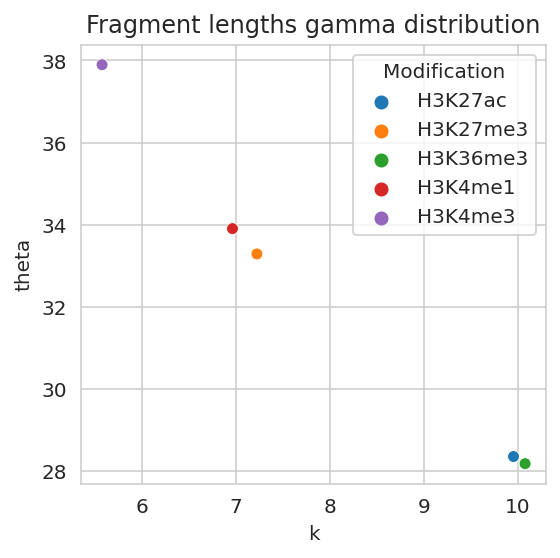

In [4]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths gamma distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_gamma.pdf'), bbox_inches='tight', dpi=300)
plt.show()

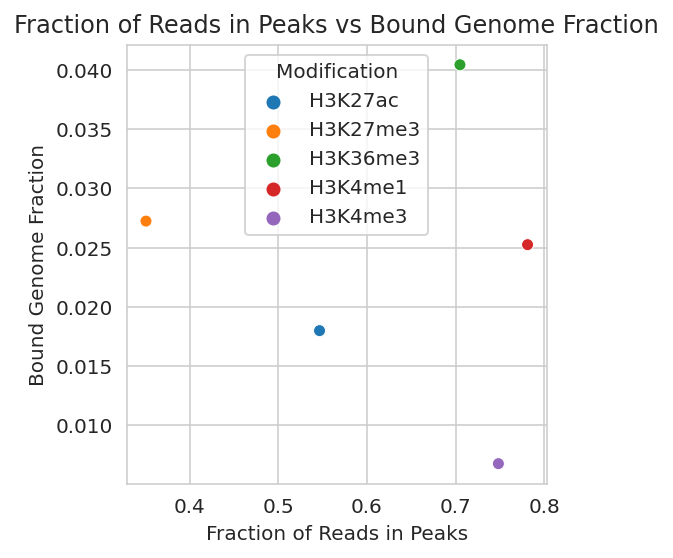

In [5]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [6]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [7]:
original_peaks = {
    'H3K27ac': PATH + '/models/H3K27ac_100_0.05_3.peak',
    'H3K27me3' : PATH + '/models/H3K27me3_100_0.05_3.peak',
    'H3K36me3': PATH + '/models/H3K36me3_100_0.05_3.peak',
    'H3K4me1': PATH + '/models/H3K4me1_100_0.05_3.peak',
    'H3K4me3': PATH + '/models/H3K4me3_100_0.05_3.peak'
}
original_peaks

{'H3K27ac': '/home/jetbrains/data/2023_chips/models/H3K27ac_100_0.05_3.peak',
 'H3K27me3': '/home/jetbrains/data/2023_chips/models/H3K27me3_100_0.05_3.peak',
 'H3K36me3': '/home/jetbrains/data/2023_chips/models/H3K36me3_100_0.05_3.peak',
 'H3K4me1': '/home/jetbrains/data/2023_chips/models/H3K4me1_100_0.05_3.peak',
 'H3K4me3': '/home/jetbrains/data/2023_chips/models/H3K4me3_100_0.05_3.peak'}

In [8]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [9]:
from itertools import product
# Modification Mult Library I TruePeaksFile TruePeaks TrueLength Tool PeaksFile Fdr Peaks Length PrecisionP RecallP Intersection
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], range(1, N + 1), MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 0:
            df_fdr.loc[len(df_fdr)] = (res[0], m, n, mult)
    return df_fdr

In [10]:
df_macs2 = load_peaks(PATH + '/macs2', '.narrowPeak')
df_macs2['tool'] = 'MACS2'
df_macs2

0it [00:00, ?it/s]

,file,modification,n,multiplier,tool
0,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,1.0,MACS2
1,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.7,MACS2
2,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.5,MACS2
3,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.2,MACS2
4,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.1,MACS2
...,...,...,...,...,...
145,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,1.0,MACS2
146,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.7,MACS2
147,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.5,MACS2
148,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.2,MACS2


In [11]:
df_macs2broad = load_peaks(PATH + '/macs2', '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
df_macs2broad

0it [00:00, ?it/s]

,file,modification,n,multiplier,tool
0,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,1.0,MACS2 broad
1,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.7,MACS2 broad
2,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.5,MACS2 broad
3,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.2,MACS2 broad
4,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,1,0.1,MACS2 broad
...,...,...,...,...,...
145,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,1.0,MACS2 broad
146,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.7,MACS2 broad
147,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.5,MACS2 broad
148,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.2,MACS2 broad


In [12]:
df_span = load_peaks(PATH + '/span', '.peak')
df_span['tool'] = 'SPAN'
df_span

0it [00:00, ?it/s]

,file,modification,n,multiplier,tool
0,/home/jetbrains/data/2023_chips/span/H3K4me3_c...,H3K4me3,1,1.0,SPAN
1,/home/jetbrains/data/2023_chips/span/H3K4me3_c...,H3K4me3,1,0.7,SPAN
2,/home/jetbrains/data/2023_chips/span/H3K4me3_c...,H3K4me3,1,0.5,SPAN
3,/home/jetbrains/data/2023_chips/span/H3K4me3_c...,H3K4me3,1,0.2,SPAN
4,/home/jetbrains/data/2023_chips/span/H3K4me3_c...,H3K4me3,1,0.1,SPAN
...,...,...,...,...,...
145,/home/jetbrains/data/2023_chips/span/mixed_chr...,mixed,5,1.0,SPAN
146,/home/jetbrains/data/2023_chips/span/mixed_chr...,mixed,5,0.7,SPAN
147,/home/jetbrains/data/2023_chips/span/mixed_chr...,mixed,5,0.5,SPAN
148,/home/jetbrains/data/2023_chips/span/mixed_chr...,mixed,5,0.2,SPAN


In [13]:
df_sicer = load_peaks(PATH + '/sicer', 'FDR0.01')
df_sicer['tool'] = 'SICER'
df_sicer

0it [00:00, ?it/s]

,file,modification,n,multiplier,tool
0,/home/jetbrains/data/2023_chips/sicer/H3K4me3_...,H3K4me3,1,1.0,SICER
1,/home/jetbrains/data/2023_chips/sicer/H3K4me3_...,H3K4me3,1,0.7,SICER
2,/home/jetbrains/data/2023_chips/sicer/H3K4me3_...,H3K4me3,1,0.5,SICER
3,/home/jetbrains/data/2023_chips/sicer/H3K4me3_...,H3K4me3,1,0.2,SICER
4,/home/jetbrains/data/2023_chips/sicer/H3K4me3_...,H3K4me3,1,0.1,SICER
...,...,...,...,...,...
145,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,5,1.0,SICER
146,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,5,0.7,SICER
147,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,5,0.5,SICER
148,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,5,0.2,SICER


In [14]:
df = pd.concat([df_macs2, df_macs2broad, df_span, df_sicer]).reset_index(drop=True)
df.sample(5)

,file,modification,n,multiplier,tool
442,/home/jetbrains/data/2023_chips/span/mixed_chr...,mixed,4,0.5,SPAN
224,/home/jetbrains/data/2023_chips/macs2/H3K4me1_...,H3K4me1,5,0.1,MACS2 broad
375,/home/jetbrains/data/2023_chips/span/H3K27me3_...,H3K27me3,1,1.0,SPAN
302,/home/jetbrains/data/2023_chips/span/H3K4me3_c...,H3K4me3,1,0.5,SPAN
256,/home/jetbrains/data/2023_chips/macs2/H3K36me3...,H3K36me3,2,0.7,MACS2 broad


## Estimate overlap with ground truth peaks

In [15]:
tf = tempfile.mktemp()
t = []
for _, (file, m, n) in tqdm(df[['file', 'modification', 'n']].iterrows()):
    true_peaks_file = sampled_peaks[(m, n)]
    true_peaks = lines(true_peaks_file)
    true_length = bedl(true_peaks_file).sum()
    peaks = lines(file)
    length = bedl(file).sum()
    true_peaks_file_s = sorted_file(true_peaks_file)
    file_s = sorted_file(file)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
    recall = lines(tf)
    recall_len = bedl(tf).sum()
    !bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
    precision = lines(tf)
    precision_len = bedl(tf).sum()
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    t.append((true_peaks_file, true_peaks, true_length, peaks, length, precision, recall, precision_len, recall_len, overlap_len))
t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                             'peaks', 'length', 'precision', 'recall', 'precision_len', 'recall_len', 'overlap_len'])
t

0it [00:00, ?it/s]

,true_peaks_file,true_peaks,true_length,peaks,length,precision,recall,precision_len,recall_len,overlap_len
0,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,634686,383,650474.0,379,370,649609.0,594442.0,582523
1,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,634686,358,622341.0,351,342,620729.0,580856.0,565741
2,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,634686,326,626517.0,323,320,625525.0,571780.0,556868
3,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,634686,266,514994.0,265,243,514695.0,505885.0,487967
4,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,634686,266,238406.0,266,175,238406.0,419057.0,234154
...,...,...,...,...,...,...,...,...,...,...
595,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2287816,393,2352207.0,393,401,2352207.0,2250660.0,2242239
596,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2287816,373,2344627.0,373,381,2344627.0,2236289.0,2223243
597,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2287816,359,2346241.0,349,355,2332651.0,2215214.0,2195602
598,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2287816,696,2821304.0,305,306,2247495.0,2153597.0,2104903


In [16]:
for c in t.columns:
    df[c] = list(t[c])
del t
df.sample(5)

,file,modification,n,multiplier,tool,true_peaks_file,true_peaks,true_length,peaks,length,precision,recall,precision_len,recall_len,overlap_len
186,/home/jetbrains/data/2023_chips/macs2/H3K27ac_...,H3K27ac,3,0.7,MACS2 broad,/home/jetbrains/data/2023_chips/fastq/H3K27ac_...,500,1254675,392,1217013.0,386,385,1213394.0,1194188.0,1158653
535,/home/jetbrains/data/2023_chips/sicer/H3K27me3...,H3K27me3,3,1.0,SICER,/home/jetbrains/data/2023_chips/fastq/H3K27me3...,500,2032325,531,2288669.0,407,407,2093393.0,1930571.0,1911563
37,/home/jetbrains/data/2023_chips/macs2/H3K27ac_...,H3K27ac,3,0.5,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K27ac_...,500,1254675,371,1056974.0,370,310,1056675.0,1098488.0,1025189
104,/home/jetbrains/data/2023_chips/macs2/H3K36me3...,H3K36me3,1,0.1,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K36me3...,500,3900335,0,0.0,0,0,0.0,0.0,0
587,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,3,0.5,SICER,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2193896,374,2274026.0,352,361,2241848.0,2115523.0,2098829


In [17]:
df['Precision'] = df['precision'] / df['peaks']
df['Recall'] = df['recall'] / df['true_peaks']
df['PrecisionL'] = df['precision_len'] / df['length']
df['RecallL'] = df['recall_len'] / df['true_length']

df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df['Precision'], df['Recall'])]
df['F1L'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df['PrecisionL'], df['RecallL'])]
df['Jaccard'] = df['overlap_len'] / (df['true_length'] + df['length'] - df['overlap_len'])
df.sample(5)

,file,modification,n,multiplier,tool,true_peaks_file,true_peaks,true_length,peaks,length,...,precision_len,recall_len,overlap_len,Precision,Recall,PrecisionL,RecallL,F1,F1L,Jaccard
80,/home/jetbrains/data/2023_chips/macs2/H3K27me3...,H3K27me3,2,1.0,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K27me3...,500,1891621,466,1454138.0,...,1452268.0,1603234.0,1427944,0.989270,0.610,0.998714,0.847545,0.754663,0.916941,0.744568
430,/home/jetbrains/data/2023_chips/span/mixed_chr...,mixed,2,1.0,SPAN,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2231769,413,2186885.0,...,2186885.0,2174719.0,2122393,1.000000,0.788,1.000000,0.974437,0.881432,0.987053,0.924282
517,/home/jetbrains/data/2023_chips/sicer/H3K4me1_...,H3K4me1,4,0.5,SICER,/home/jetbrains/data/2023_chips/fastq/H3K4me1_...,500,941911,651,1491749.0,...,1128015.0,894948.0,888341,0.591398,0.770,0.756169,0.950141,0.668983,0.842130,0.574859
299,/home/jetbrains/data/2023_chips/macs2/mixed_ch...,mixed,5,0.1,MACS2 broad,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2287816,0,0.0,...,0.0,0.0,0,NaN,0.000,NaN,0.000000,0.000000,0.000000,0.000000
204,/home/jetbrains/data/2023_chips/macs2/H3K4me1_...,H3K4me1,1,0.1,MACS2 broad,/home/jetbrains/data/2023_chips/fastq/H3K4me1_...,500,826924,0,0.0,...,0.0,0.0,0,NaN,0.000,NaN,0.000000,0.000000,0.000000,0.000000


In [18]:
def with_quality(df, add_all=False):
    ts = []

    t = df.loc[df['multiplier'] == 1.0].copy()
    t['quality'] = '100%'
    ts.append(t)

    t = df.loc[df['multiplier'] == 0.7].copy()
    t['quality'] = '70%'
    ts.append(t)

    t = df.loc[df['multiplier'] == 0.5].copy()
    t['quality'] = '50%'
    ts.append(t)

    t = df.loc[df['multiplier'] == 0.2].copy()
    t['quality'] = '20%'
    ts.append(t)

    t = df.loc[df['multiplier'] == 0.1].copy()
    t['quality'] = '10%'
    ts.append(t)

    if add_all:
        t = df.copy()
        t['quality'] = 'All'
        ts.append(t)
    return pd.concat(ts)

df = with_quality(df)
df.sample(5)

,file,modification,n,multiplier,tool,true_peaks_file,true_peaks,true_length,peaks,length,...,recall_len,overlap_len,Precision,Recall,PrecisionL,RecallL,F1,F1L,Jaccard,quality
473,/home/jetbrains/data/2023_chips/sicer/H3K4me3_...,H3K4me3,5,0.2,SICER,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,637894,881,1612919.0,...,549443.0,546692,0.347333,0.612,0.459846,0.861339,0.443157,0.599588,0.320806,20%
577,/home/jetbrains/data/2023_chips/sicer/mixed_ch...,mixed,1,0.5,SICER,/home/jetbrains/data/2023_chips/fastq/mixed_ch...,500,2377076,348,2401052.0,...,2290304.0,2266281,0.971264,0.690,0.993674,0.963496,0.806822,0.978352,0.902237,50%
122,/home/jetbrains/data/2023_chips/macs2/H3K36me3...,H3K36me3,5,0.5,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K36me3...,500,3743779,818,3174598.0,...,3401879.0,3163229,0.998778,0.512,0.999906,0.908675,0.676968,0.952110,0.842371,50%
119,/home/jetbrains/data/2023_chips/macs2/H3K36me3...,H3K36me3,4,0.1,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K36me3...,500,3989247,0,0.0,...,0.0,0,NaN,0.000,NaN,0.000000,0.000000,0.000000,0.000000,10%
23,/home/jetbrains/data/2023_chips/macs2/H3K4me3_...,H3K4me3,5,0.2,MACS2,/home/jetbrains/data/2023_chips/fastq/H3K4me3_...,500,637894,286,510752.0,...,507842.0,482050,0.993007,0.500,0.998418,0.796123,0.665105,0.885868,0.723152,20%


In [19]:
df['multiplier'].unique()

array([1. , 0.7, 0.5, 0.2, 0.1])

# Peaks number and lengths

In [20]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

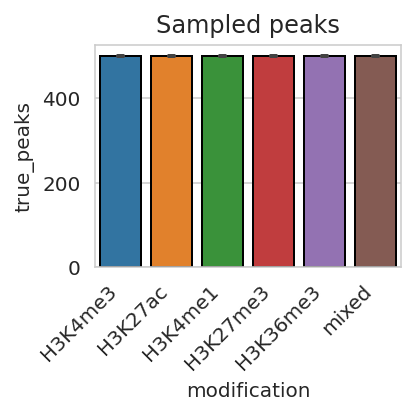

In [21]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df, x="modification", y="true_peaks",
           capsize=.1, errwidth=2, edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [22]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

,length,modification
0,482,H3K27ac
1,2844,H3K27ac
2,27042,H3K27ac
3,260,H3K27ac
4,538,H3K27ac
...,...,...
99995,2246,H3K4me3
99996,2946,H3K4me3
99997,2343,H3K4me3
99998,1427,H3K4me3


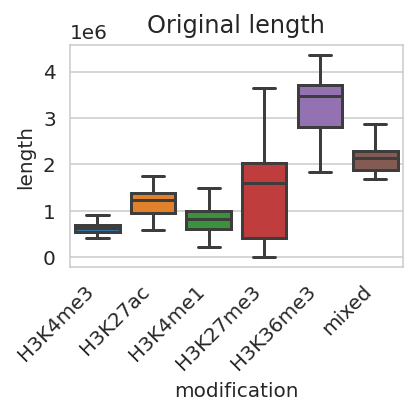

In [23]:
fig = plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

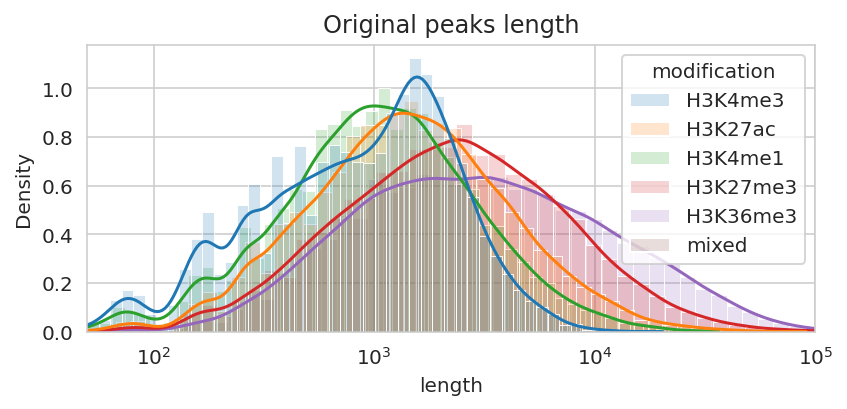

In [24]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_results.set(xscale='log')
g_results.set_xlim(50, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [25]:
ts = []
for _, (m, file) in df[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

,length,modification
0,277,H3K4me3
1,458,H3K4me3
2,477,H3K4me3
3,762,H3K4me3
4,582,H3K4me3
...,...,...
299995,2093,mixed
299996,656,mixed
299997,5952,mixed
299998,671,mixed


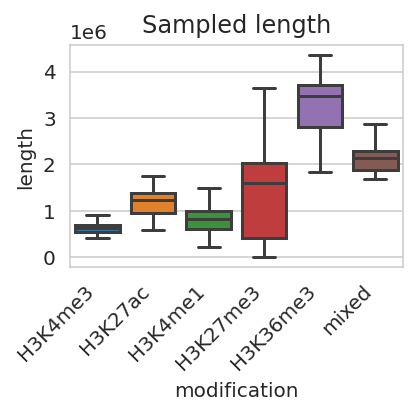

In [26]:
fig = plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

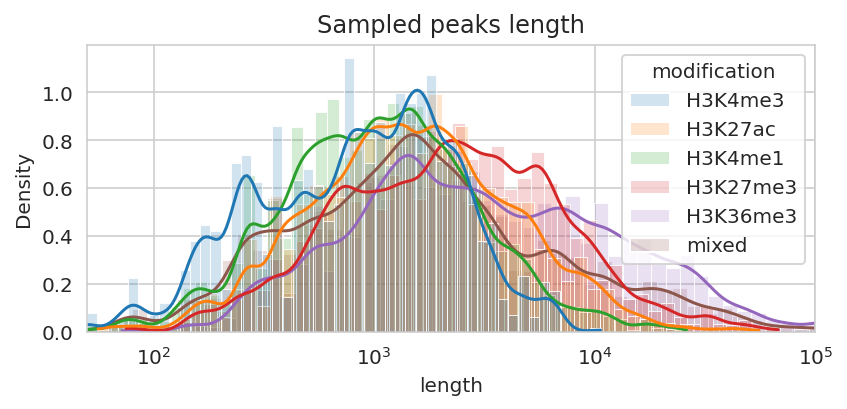

In [27]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_results.set(xscale='log')
g_results.set_xlim(50, 1e5)
ax.title.set_text('Sampled peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

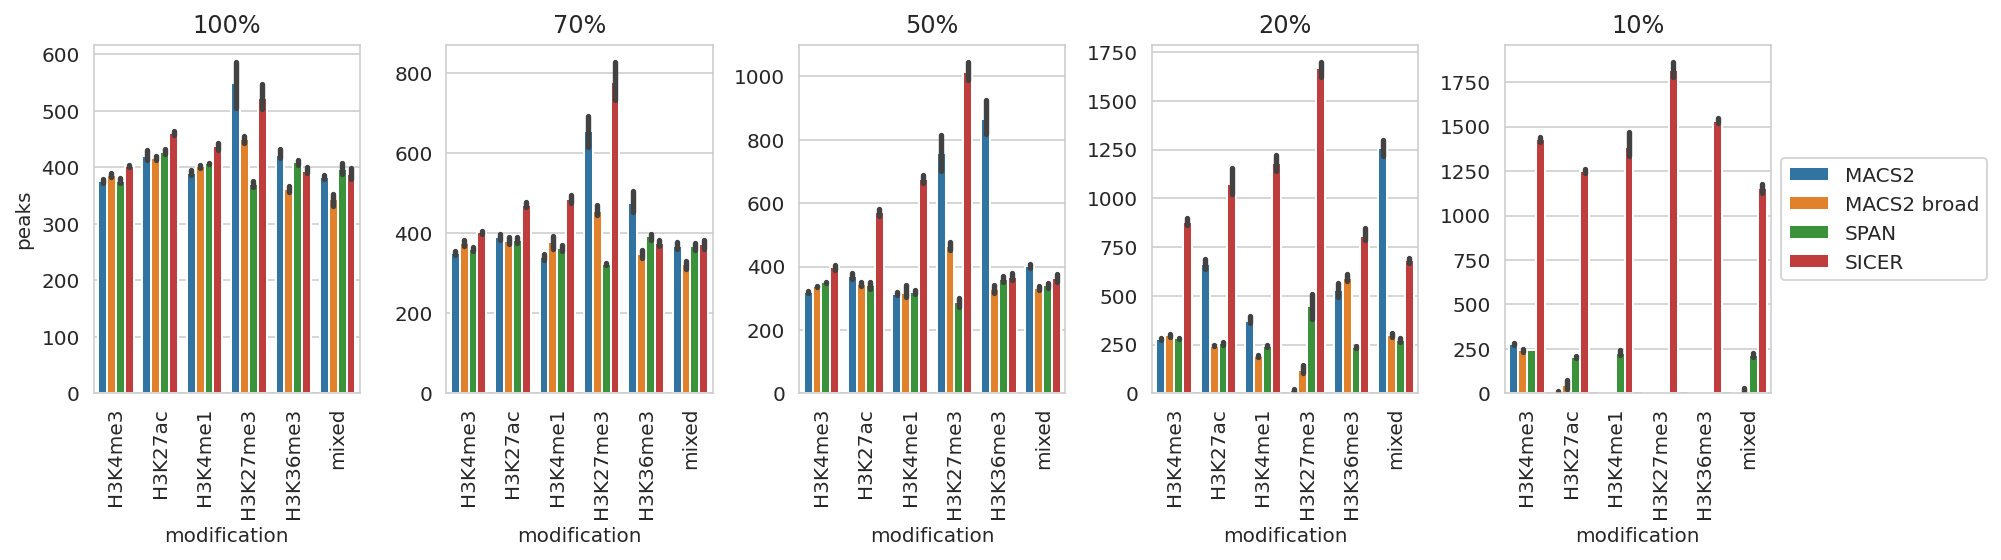

In [28]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [29]:
ts = []
for _, (m, q, tool, file) in df[['modification', 'quality', 'tool', 'file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    t['quality'] = q
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

,length,modification,quality,tool
0,1854.0,H3K4me3,100%,MACS2
1,1626.0,H3K4me3,100%,MACS2
2,730.0,H3K4me3,100%,MACS2
3,2662.0,H3K4me3,100%,MACS2
4,750.0,H3K4me3,100%,MACS2
...,...,...,...,...
266521,399.0,mixed,10%,SICER
266522,1399.0,mixed,10%,SICER
266523,1799.0,mixed,10%,SICER
266524,1599.0,mixed,10%,SICER


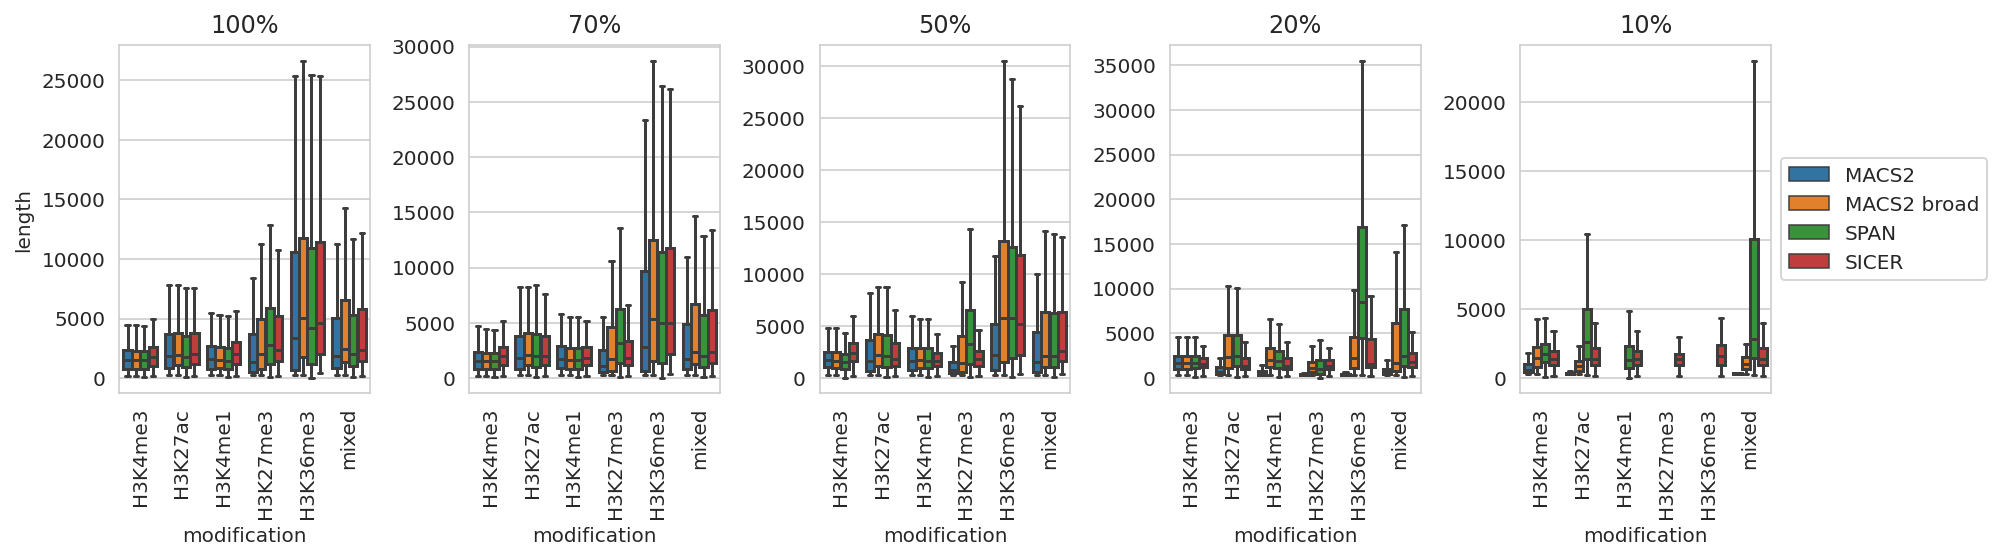

In [30]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=t[t['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard, precision, recall, F1

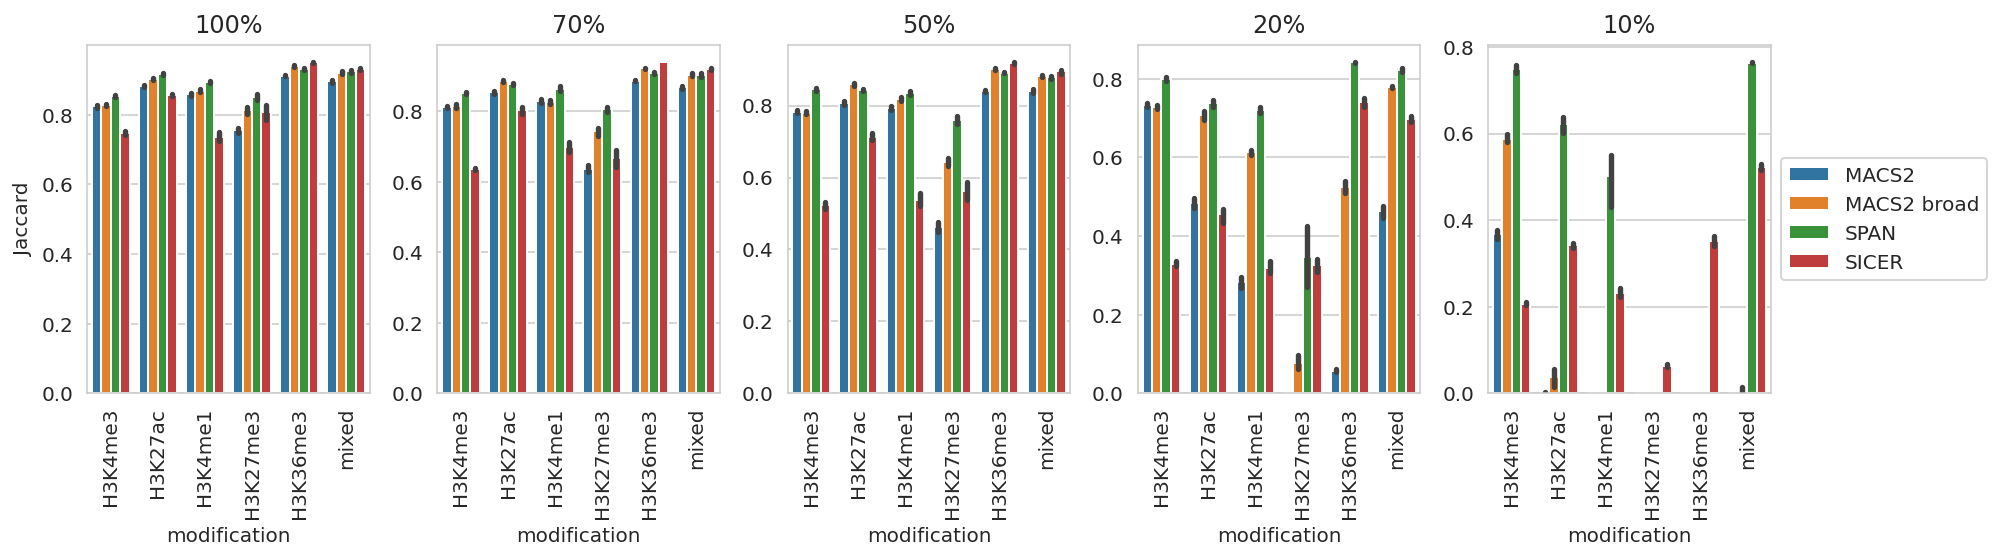

In [31]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

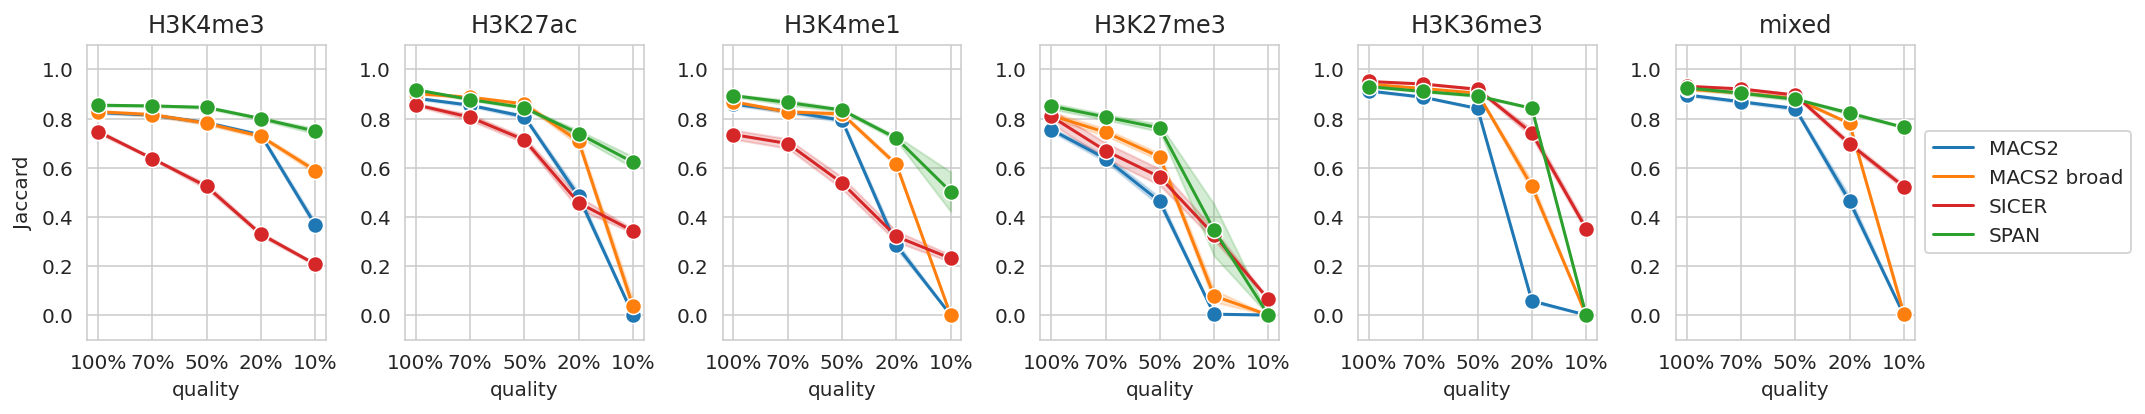

In [32]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df[df['modification']==m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                 palette=TOOLS_PALETTE,
                 errorbar='sd', marker='o', markersize=8)
    # ax.xaxis.set_tick_params(rotation=45)
    # ax.set_xticks(range(5), minor=False)
    # ax.set_xticklabels(['100%',  '50%', '20%'])
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

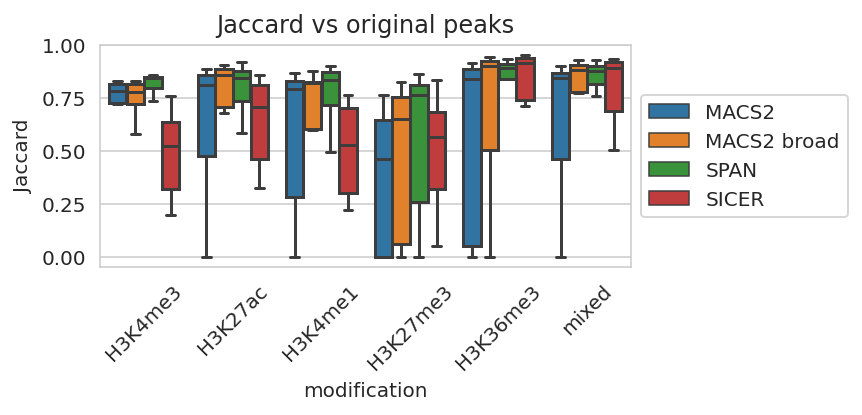

In [33]:
plt.figure(figsize=(6, 3))
g_results = sns.boxplot(data=df,
                        x='modification', y='Jaccard', hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False
                        # errorbar='se', marker='o', markersize=8
                        )
ax = g_results.axes
ax.set_title('Jaccard vs original peaks')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [34]:
t = []
for m, n, tool in tqdm(product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                               df['n'].unique(), df['tool'].unique())):
    print(m, n, tool)
    dft = df[(df['modification'] == m) & (df['n'] == n) & (df['tool'] == tool)].copy()
    dft.sort_values(by=['multiplier'], inplace=True)
    aj = 0
    mprev = 0
    for _, row in dft.iterrows():
        aj += (row['multiplier'] - mprev) * row['Jaccard']
        mprev = row['multiplier']
        t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc

0it [00:00, ?it/s]

H3K4me3 1 MACS2
H3K4me3 1 MACS2 broad
H3K4me3 1 SPAN
H3K4me3 1 SICER
H3K4me3 2 MACS2
H3K4me3 2 MACS2 broad
H3K4me3 2 SPAN
H3K4me3 2 SICER
H3K4me3 3 MACS2
H3K4me3 3 MACS2 broad
H3K4me3 3 SPAN
H3K4me3 3 SICER
H3K4me3 4 MACS2
H3K4me3 4 MACS2 broad
H3K4me3 4 SPAN
H3K4me3 4 SICER
H3K4me3 5 MACS2
H3K4me3 5 MACS2 broad
H3K4me3 5 SPAN
H3K4me3 5 SICER
H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SPAN
H3K27ac 1 SICER
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SPAN
H3K27ac 2 SICER
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SPAN
H3K27ac 3 SICER
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SPAN
H3K27ac 4 SICER
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SPAN
H3K27ac 5 SICER
H3K4me1 1 MACS2
H3K4me1 1 MACS2 broad
H3K4me1 1 SPAN
H3K4me1 1 SICER
H3K4me1 2 MACS2
H3K4me1 2 MACS2 broad
H3K4me1 2 SPAN
H3K4me1 2 SICER
H3K4me1 3 MACS2
H3K4me1 3 MACS2 broad
H3K4me1 3 SPAN
H3K4me1 3 SICER
H3K4me1 4 MACS2
H3K4me1 4 MACS2 broad
H3K4me1 4 SPAN
H3K4me1 4 SICER
H3K4me1 5 MACS2
H3K4me1 5 MACS2 br

,modification,n,tool,AUC
0,H3K4me3,1,MACS2,0.036647
1,H3K4me3,1,MACS2,0.110390
2,H3K4me3,1,MACS2,0.347579
3,H3K4me3,1,MACS2,0.511257
4,H3K4me3,1,MACS2,0.759973
...,...,...,...,...
595,mixed,5,SICER,0.052781
596,mixed,5,SICER,0.122846
597,mixed,5,SICER,0.392968
598,mixed,5,SICER,0.577531


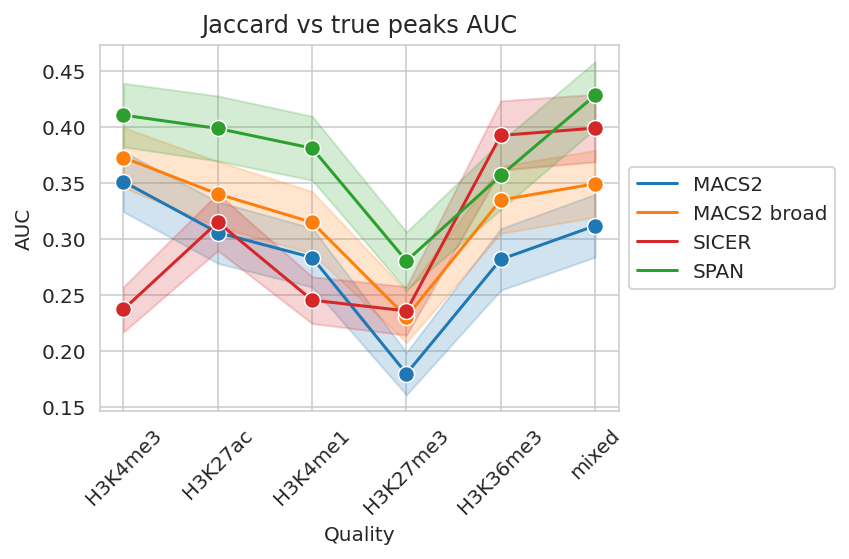

In [35]:
plt.figure(figsize=(6, 4))
g_results = sns.lineplot(data=dfjaccardauc,
                         x='modification', y='AUC', hue='tool',
                         hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                         palette=TOOLS_PALETTE,
                         errorbar=('se', .50), marker='o', markersize=8)
g_results.axes.set_xlabel('Quality')
g_results.axes.title.set_text(f'Jaccard vs true peaks AUC')
g_results.axes.xaxis.set_tick_params(rotation=45)
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: 

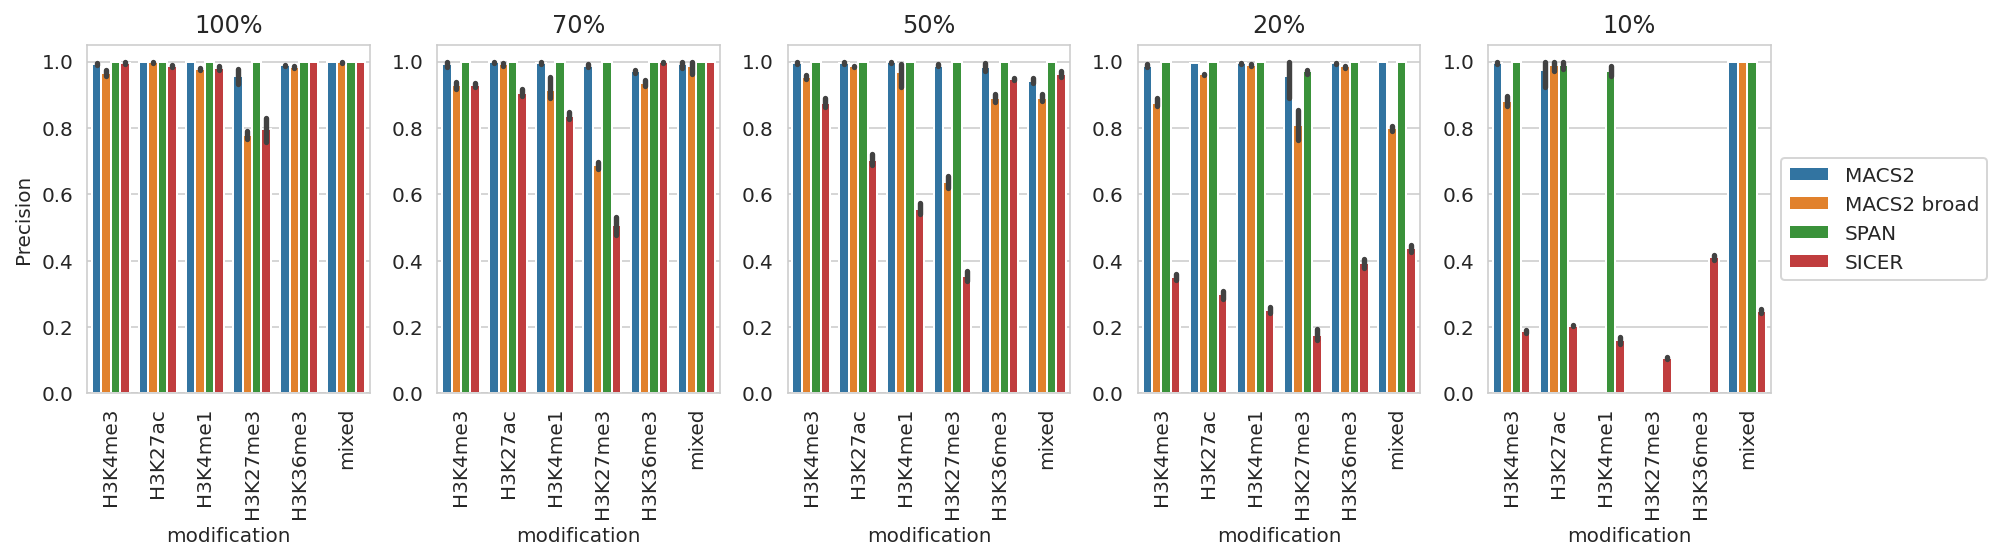

In [36]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="Precision", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'precision.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1559: 

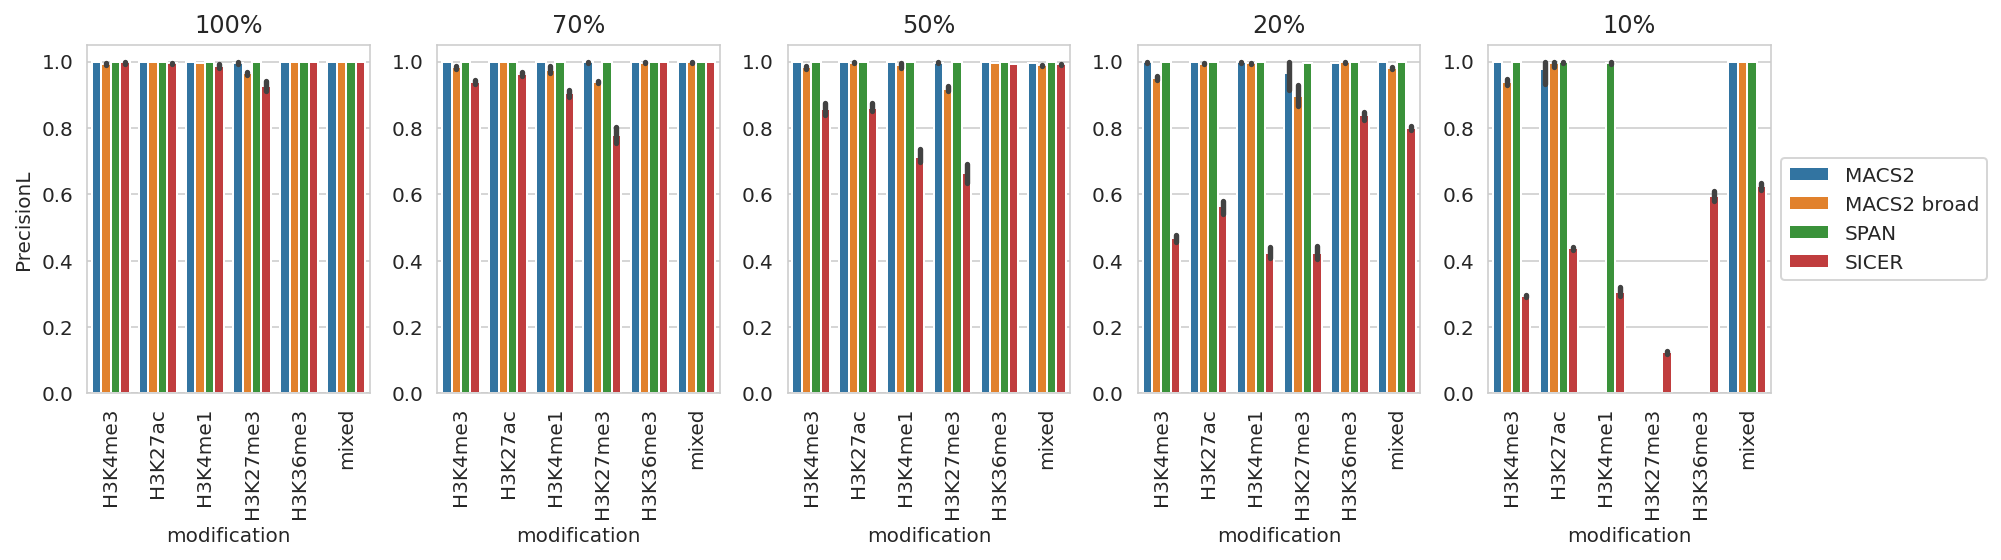

In [37]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="PrecisionL", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'precision_len.pdf'), bbox_inches='tight', dpi=300)
plt.show()

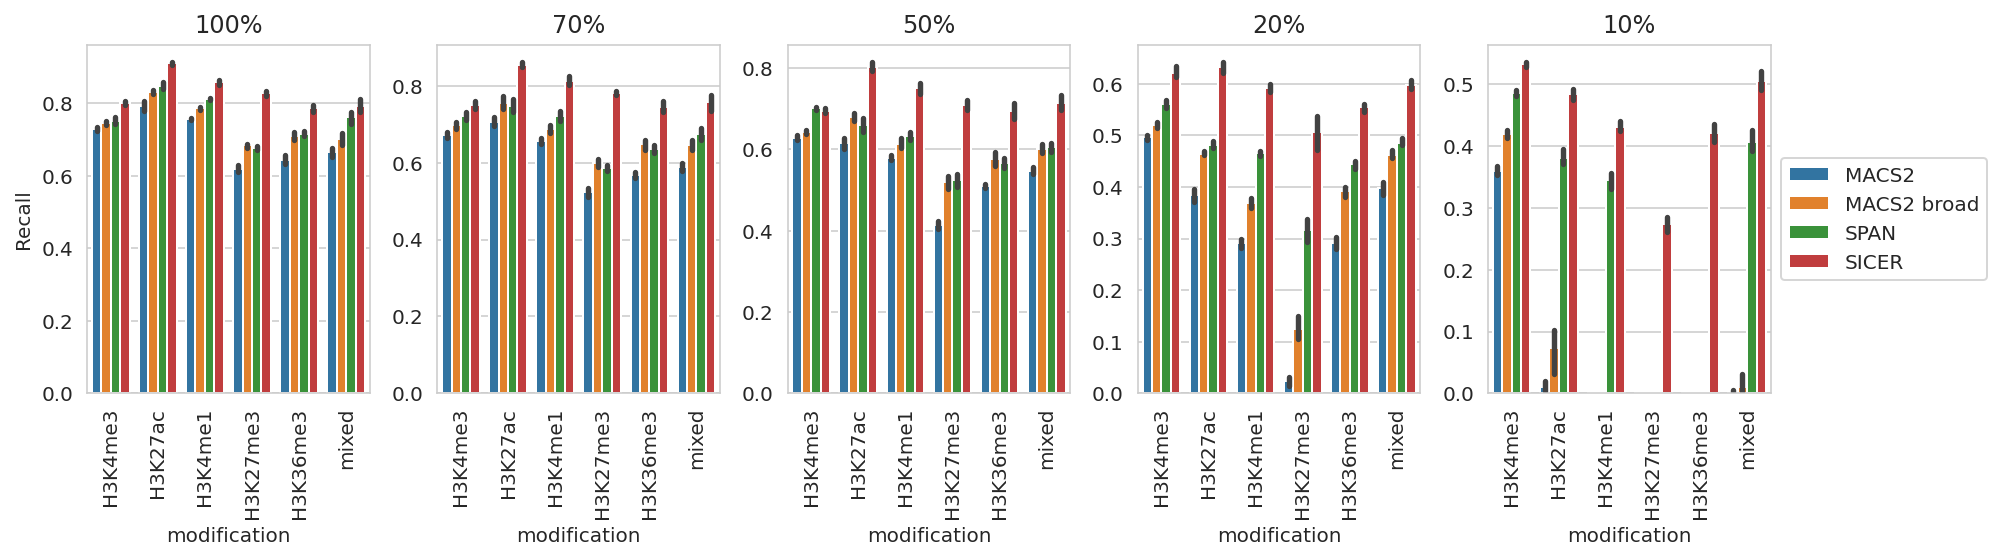

In [38]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="Recall", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'recall.pdf'), bbox_inches='tight', dpi=300)
plt.show()

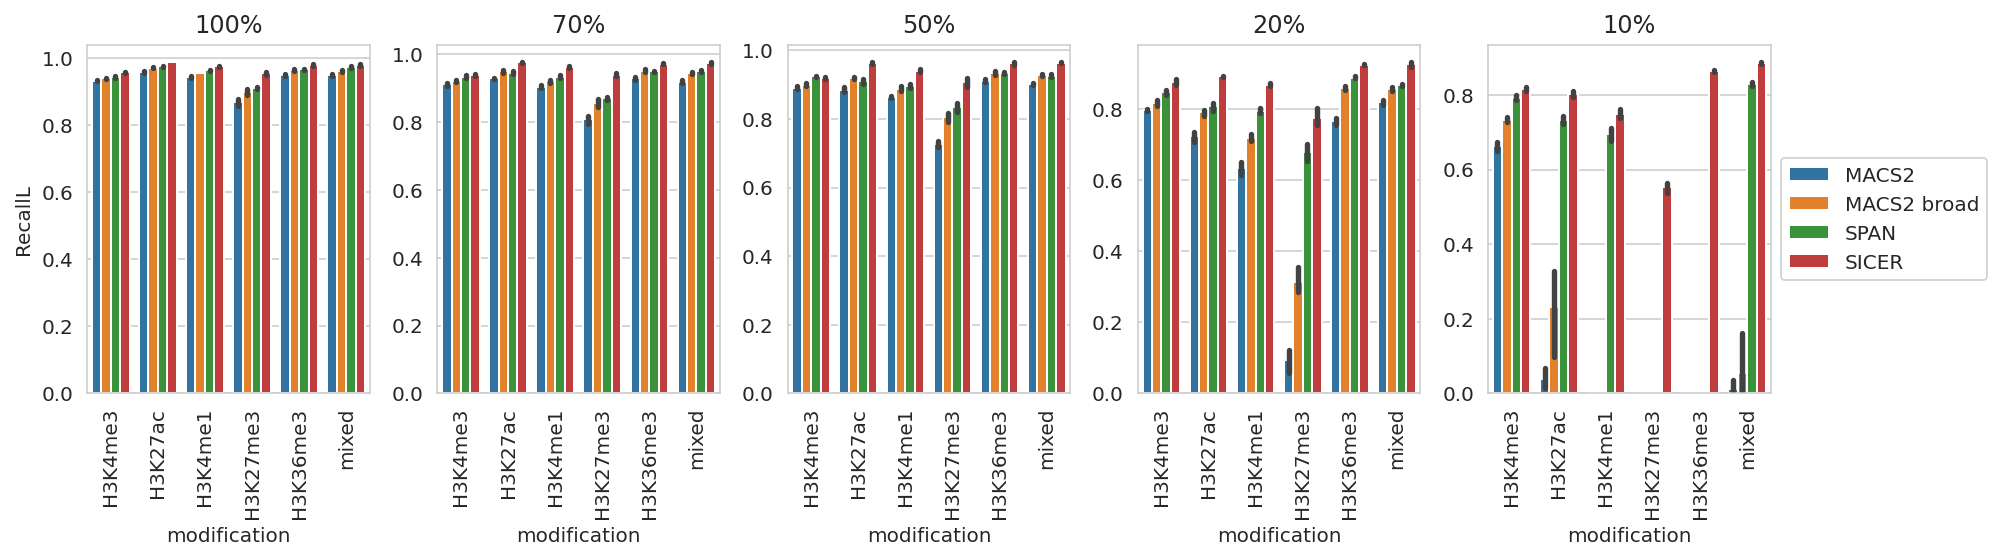

In [39]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="RecallL", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'recall_len.pdf'), bbox_inches='tight', dpi=300)
plt.show()

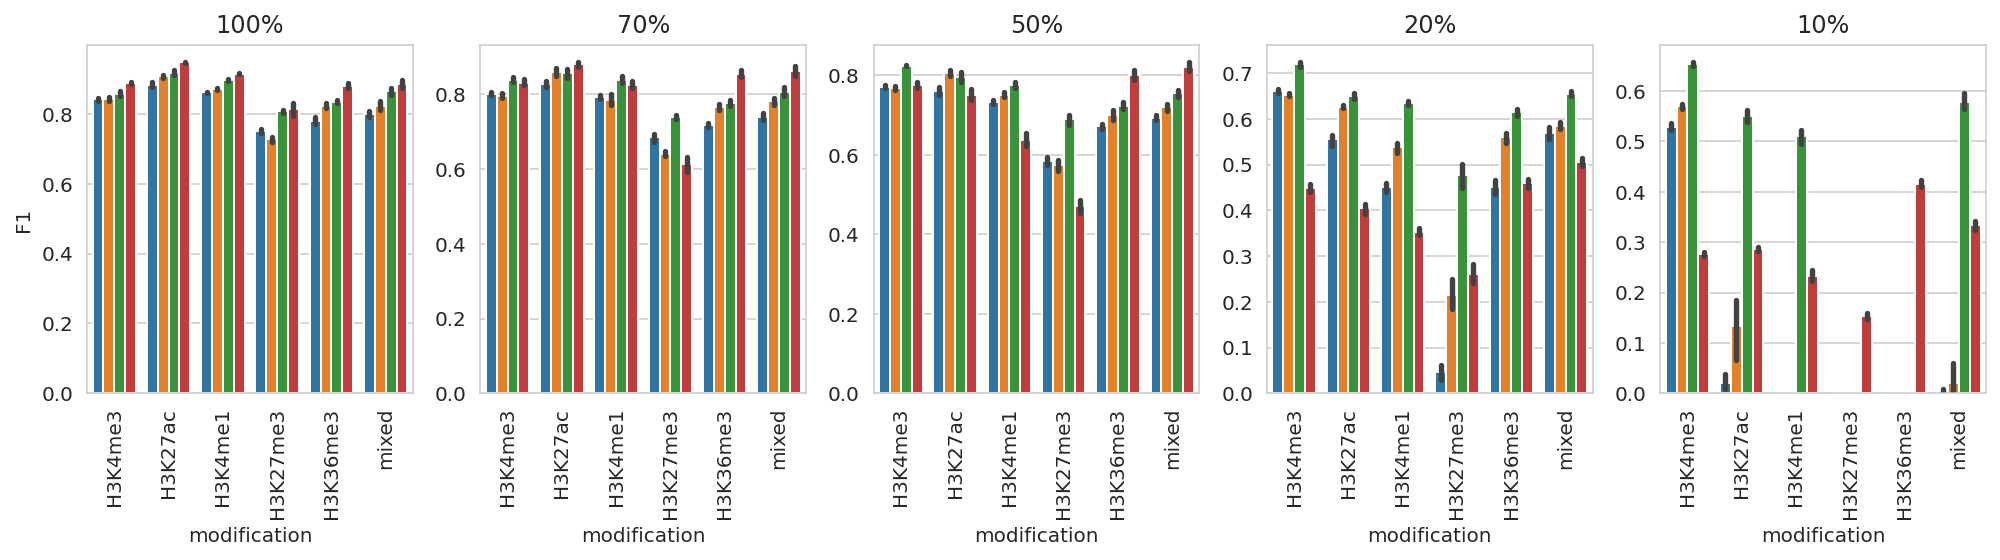

In [40]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="F1", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'f1.pdf'), bbox_inches='tight', dpi=300)
plt.show()

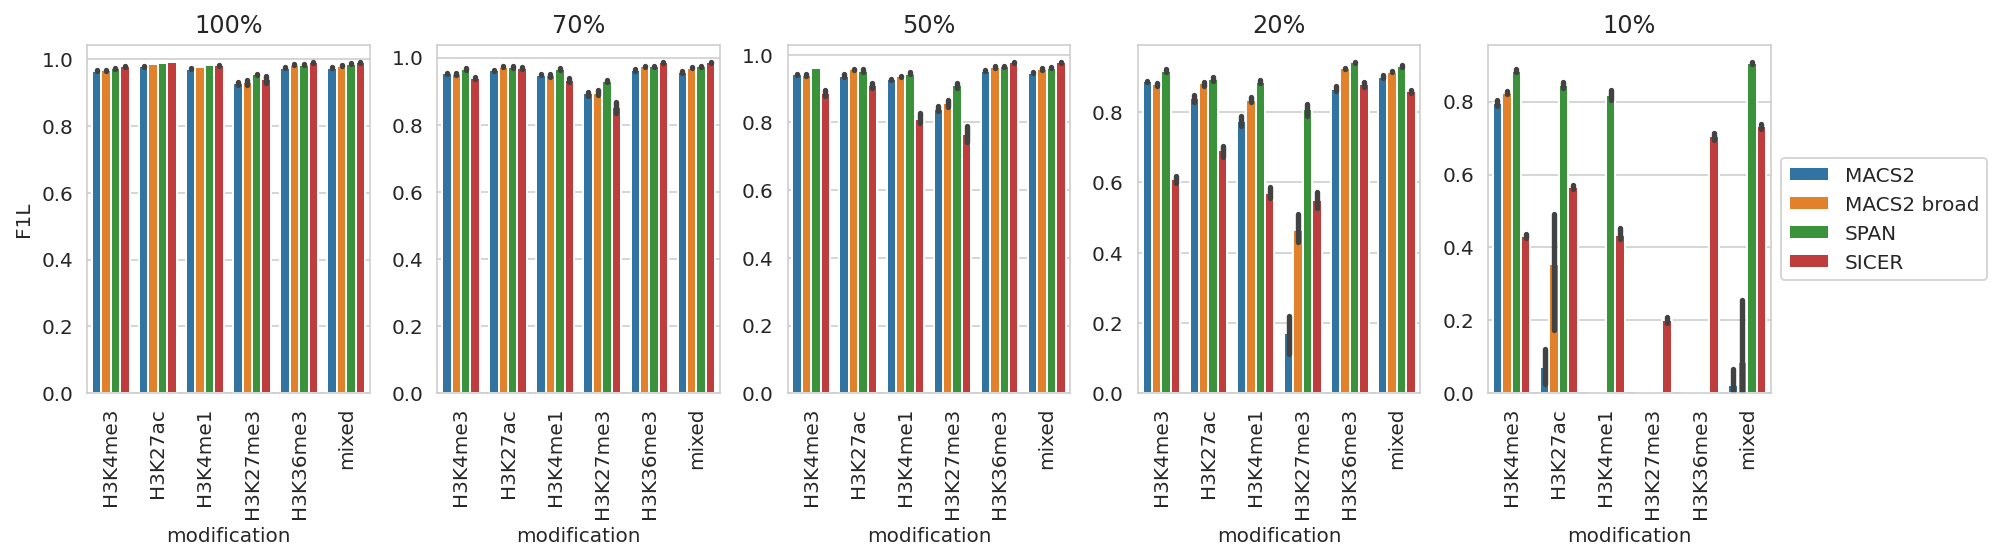

In [41]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df[df['quality']==q], x="modification", y="F1L", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == 4:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'f1l.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

  0%|          | 0/6 [00:00<?, ?it/s]

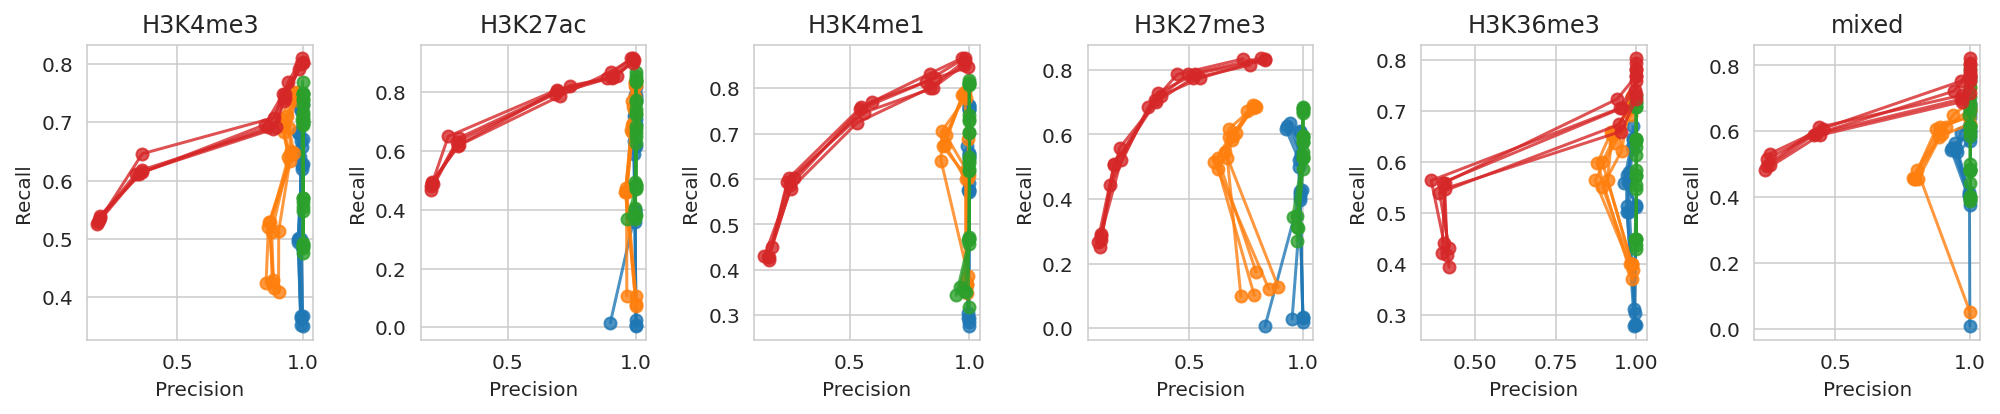

In [42]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for tool, n in product(df['tool'].unique(), range(1, N + 1)):
        dft = df[(df['modification'] == m) & (df['n'] == n) & (df['tool'] == tool)].copy()
        dft = dft[dft['Recall'] + dft['Precision'] > 0]
        dft.sort_values(by=['Recall', 'multiplier'], inplace=True)
        ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

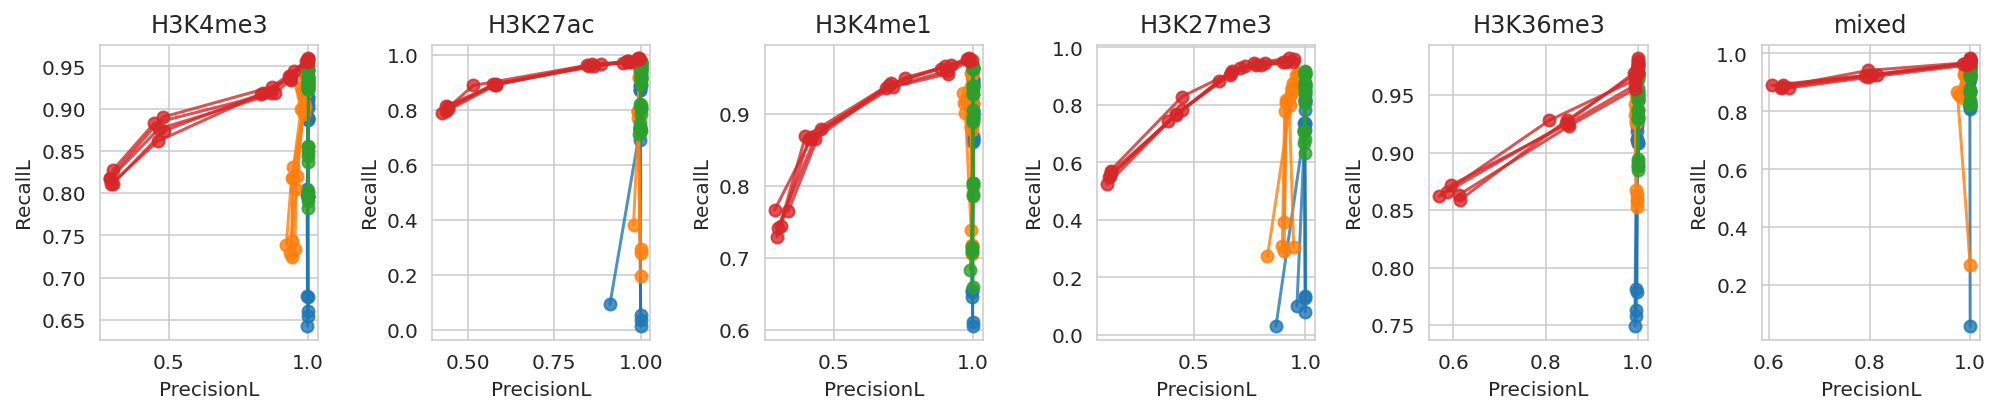

In [43]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for tool, n in product(df['tool'].unique(), range(1, N + 1)):
        dft = df[(df['modification'] == m) & (df['n'] == n) & (df['tool'] == tool)].copy()
        dft = dft[dft['RecallL'] + dft['PrecisionL'] > 0]
        dft.sort_values(by=['RecallL', 'multiplier'], inplace=True)
        ax.plot(dft['PrecisionL'], dft['RecallL'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8)
        ax.set_xlabel('PrecisionL')
        ax.set_ylabel('RecallL')
        ax.set_title(f'{m}')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc_len.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [44]:
t = []
for m, n, tool in tqdm(product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                               df['n'].unique(), df['tool'].unique())):
    print(m, n, tool)
    dft = df[(df['modification'] == m) & (df['n'] == n) & (df['tool'] == tool)].copy()
    dft = dft[dft['Recall'] + dft['Precision'] > 0]
    dft.sort_values(by=['Recall', 'multiplier'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['Recall'] - rprev) * row['Precision']
        rprev = row['Recall']
        t.append((m, n, tool, ap))
dfap = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AP'])
dfap

0it [00:00, ?it/s]

H3K4me3 1 MACS2
H3K4me3 1 MACS2 broad
H3K4me3 1 SPAN
H3K4me3 1 SICER
H3K4me3 2 MACS2
H3K4me3 2 MACS2 broad
H3K4me3 2 SPAN
H3K4me3 2 SICER
H3K4me3 3 MACS2
H3K4me3 3 MACS2 broad
H3K4me3 3 SPAN
H3K4me3 3 SICER
H3K4me3 4 MACS2
H3K4me3 4 MACS2 broad
H3K4me3 4 SPAN
H3K4me3 4 SICER
H3K4me3 5 MACS2
H3K4me3 5 MACS2 broad
H3K4me3 5 SPAN
H3K4me3 5 SICER
H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SPAN
H3K27ac 1 SICER
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SPAN
H3K27ac 2 SICER
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SPAN
H3K27ac 3 SICER
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SPAN
H3K27ac 4 SICER
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SPAN
H3K27ac 5 SICER
H3K4me1 1 MACS2
H3K4me1 1 MACS2 broad
H3K4me1 1 SPAN
H3K4me1 1 SICER
H3K4me1 2 MACS2
H3K4me1 2 MACS2 broad
H3K4me1 2 SPAN
H3K4me1 2 SICER
H3K4me1 3 MACS2
H3K4me1 3 MACS2 broad
H3K4me1 3 SPAN
H3K4me1 3 SICER
H3K4me1 4 MACS2
H3K4me1 4 MACS2 broad
H3K4me1 4 SPAN
H3K4me1 4 SICER
H3K4me1 5 MACS2
H3K4me1 5 MACS2 br

,modification,n,tool,AP
0,H3K4me3,1,MACS2,0.350000
1,H3K4me3,1,MACS2,0.485489
2,H3K4me3,1,MACS2,0.638072
3,H3K4me3,1,MACS2,0.681211
4,H3K4me3,1,MACS2,0.736626
...,...,...,...,...
545,mixed,5,SICER,0.121917
546,mixed,5,SICER,0.172750
547,mixed,5,SICER,0.268020
548,mixed,5,SICER,0.320020


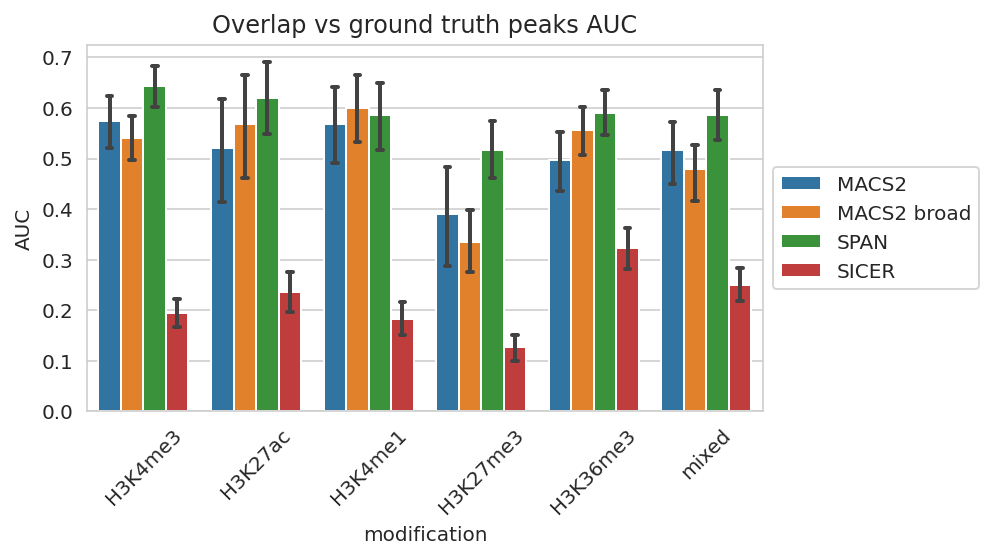

In [45]:
fig = plt.figure(figsize=(7, 4))
g_result = sns.barplot(data=dfap, x="modification", y="AP", hue='tool', capsize=.05, errwidth=2,
                       order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_result.axes.xaxis.set_tick_params(rotation=45)
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs ground truth peaks AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'ap.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [46]:
t = []
for m, n, tool in tqdm(product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                               df['n'].unique(), df['tool'].unique())):
    print(m, n, tool)
    dft = df[(df['modification'] == m) & (df['n'] == n) & (df['tool'] == tool)].copy()
    dft = dft[dft['RecallL'] + dft['PrecisionL'] > 0]
    dft.sort_values(by=['RecallL', 'multiplier'], inplace=True)
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['RecallL'] - rprev) * row['PrecisionL']
        rprev = row['RecallL']
        t.append((m, n, tool, ap))
dfapl = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'APL'])
dfapl

0it [00:00, ?it/s]

H3K4me3 1 MACS2
H3K4me3 1 MACS2 broad
H3K4me3 1 SPAN
H3K4me3 1 SICER
H3K4me3 2 MACS2
H3K4me3 2 MACS2 broad
H3K4me3 2 SPAN
H3K4me3 2 SICER
H3K4me3 3 MACS2
H3K4me3 3 MACS2 broad
H3K4me3 3 SPAN
H3K4me3 3 SICER
H3K4me3 4 MACS2
H3K4me3 4 MACS2 broad
H3K4me3 4 SPAN
H3K4me3 4 SICER
H3K4me3 5 MACS2
H3K4me3 5 MACS2 broad
H3K4me3 5 SPAN
H3K4me3 5 SICER
H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 SPAN
H3K27ac 1 SICER
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 SPAN
H3K27ac 2 SICER
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 SPAN
H3K27ac 3 SICER
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 SPAN
H3K27ac 4 SICER
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 SPAN
H3K27ac 5 SICER
H3K4me1 1 MACS2
H3K4me1 1 MACS2 broad
H3K4me1 1 SPAN
H3K4me1 1 SICER
H3K4me1 2 MACS2
H3K4me1 2 MACS2 broad
H3K4me1 2 SPAN
H3K4me1 2 SICER
H3K4me1 3 MACS2
H3K4me1 3 MACS2 broad
H3K4me1 3 SPAN
H3K4me1 3 SICER
H3K4me1 4 MACS2
H3K4me1 4 MACS2 broad
H3K4me1 4 SPAN
H3K4me1 4 SICER
H3K4me1 5 MACS2
H3K4me1 5 MACS2 br

,modification,n,tool,APL
0,H3K4me3,1,MACS2,0.660259
1,H3K4me3,1,MACS2,0.796984
2,H3K4me3,1,MACS2,0.900643
3,H3K4me3,1,MACS2,0.914906
4,H3K4me3,1,MACS2,0.936283
...,...,...,...,...
545,mixed,5,SICER,0.555424
546,mixed,5,SICER,0.599503
547,mixed,5,SICER,0.626280
548,mixed,5,SICER,0.635492


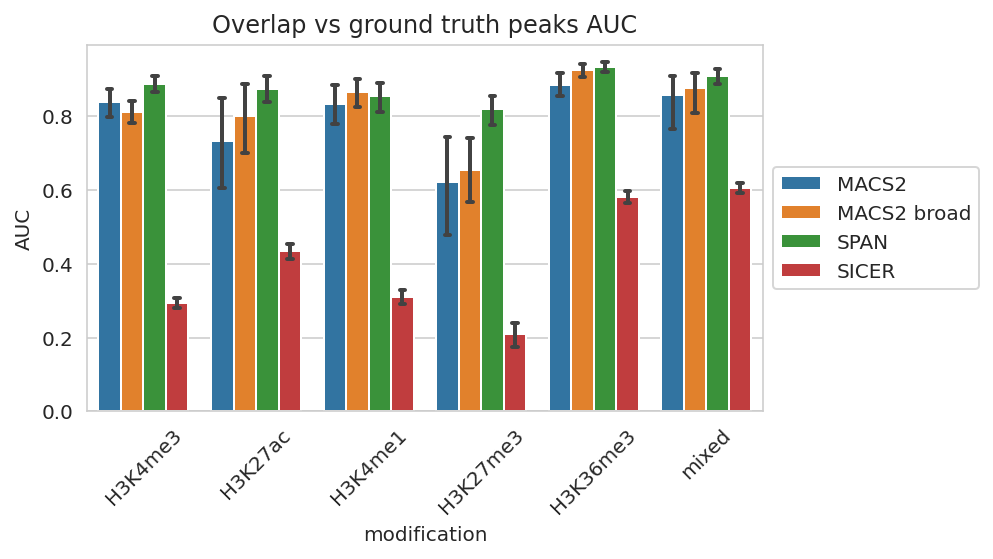

In [47]:
fig = plt.figure(figsize=(7, 4))
g_result = sns.barplot(data=dfapl, x="modification", y="APL", hue='tool', capsize=.05, errwidth=2,
                       order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_result.axes.xaxis.set_tick_params(rotation=45)
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Overlap vs ground truth peaks AUC')
plt.ylabel('AUC')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'apl.pdf'), bbox_inches='tight', dpi=300)
plt.show()